In [1]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src')
from dota import Match
from utils import plot_player_signals

2022-10-11 15:37:04.040 | INFO     | settings:<module>:10 - .env file exists: True
2022-10-11 15:37:04.040 | INFO     | settings:<module>:13 - ROOT_DIR='/Users/dsavostianov/proj/woodota'
2022-10-11 15:37:04.040 | INFO     | settings:<module>:19 - REPLAY_DIR='/Users/dsavostianov/proj/woodota/replays'
2022-10-11 15:37:04.040 | INFO     | settings:<module>:22 - REDIS_URL='redis://localhost'
2022-10-11 15:37:04.041 | INFO     | settings:<module>:26 - CLARITY_HOST='localhost', CLARITY_PORT=5600


In [2]:
match = Match.from_id(6676393091)
match.parse()

In [3]:
match.get_action_moments()

[{'start': -11, 'end': -4, 'clock_start': '-1:49', 'clock_end': '-1:56'},
 {'start': 50, 'end': 75, 'clock_start': '00:50', 'clock_end': '01:15'},
 {'start': 97, 'end': 104, 'clock_start': '01:37', 'clock_end': '01:44'},
 {'start': 130, 'end': 140, 'clock_start': '02:10', 'clock_end': '02:20'},
 {'start': 160, 'end': 188, 'clock_start': '02:40', 'clock_end': '03:08'},
 {'start': 207, 'end': 225, 'clock_start': '03:27', 'clock_end': '03:45'},
 {'start': 240, 'end': 265, 'clock_start': '04:00', 'clock_end': '04:25'},
 {'start': 276, 'end': 288, 'clock_start': '04:36', 'clock_end': '04:48'},
 {'start': 302, 'end': 334, 'clock_start': '05:02', 'clock_end': '05:34'},
 {'start': 377, 'end': 398, 'clock_start': '06:17', 'clock_end': '06:38'},
 {'start': 415, 'end': 421, 'clock_start': '06:55', 'clock_end': '07:01'},
 {'start': 453, 'end': 500, 'clock_start': '07:33', 'clock_end': '08:20'},
 {'start': 514, 'end': 524, 'clock_start': '08:34', 'clock_end': '08:44'},
 {'start': 549, 'end': 556, '

In [4]:
player = match.players[1]
player

MatchPlayer at match: 6676393091, slot: 1, hero_name: npc_dota_hero_pangolier, steam_id: 76561198134243802

In [ ]:
    # player: 'dota.MatchPlayer',
    # ax: Any = None,
    # zoom_start: int = None,
    # zoom_end: int = None,
    # use_minutes: bool = False,
    # hp: bool = False,
    # max_hp: bool = False,
    # dhp: bool = False,
    # sdhp: bool = False,
    # signal_hp_decreasing: bool = False,
    # signal_hp_low: bool = False,
    # deaths: bool = False,
    # as_target: bool = False,
    # as_target_escaped: bool = False,
    # as_attacker: bool = False,
    # as_attacker_kill: bool = False,

TypeError: no numeric data to plot

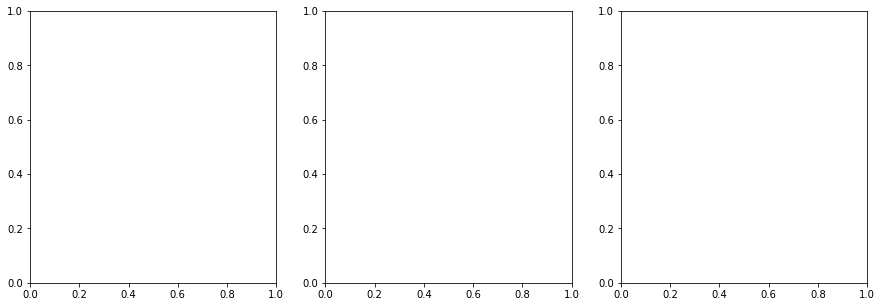

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot_player_signals(
    player,
    ax=ax[0],
    hp=True,
)

plot_player_signals(
    player,
    ax=ax[1],
    dhp=True
)

plot_player_signals(
    player,
    ax=ax[2],
    sdhp=True
)

zoom_start, zoom_end = 600, 800
fig, ax = plt.subplots(figsize=(15, 5))
plot_player_signals(
    player,
    ax=ax,
    zoom_start=zoom_start,
    zoom_end=zoom_end,
    # use_minutes=True,
    hp=True,
    # max_hp=True,
    # dhp=True,
    # sdhp=True,
    signal_hp_decreasing=True,
    signal_hp_low=True,
    deaths=True,
    # as_target=True,
    as_target_escaped=True,
    # as_attacker=True,
    # as_attacker_kill=True,
)

plt.show()

In [57]:
type(ax)

[autoreload of utils failed: Traceback (most recent call last):
  File "/Users/dsavostianov/proj/woodota/env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/dsavostianov/proj/woodota/env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/homebrew/Cellar/python@3.10/3.10.6_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/dsavostianov/proj/woodota/notebooks/../

matplotlib.axes._subplots.AxesSubplot